***

### Assignment 4

***

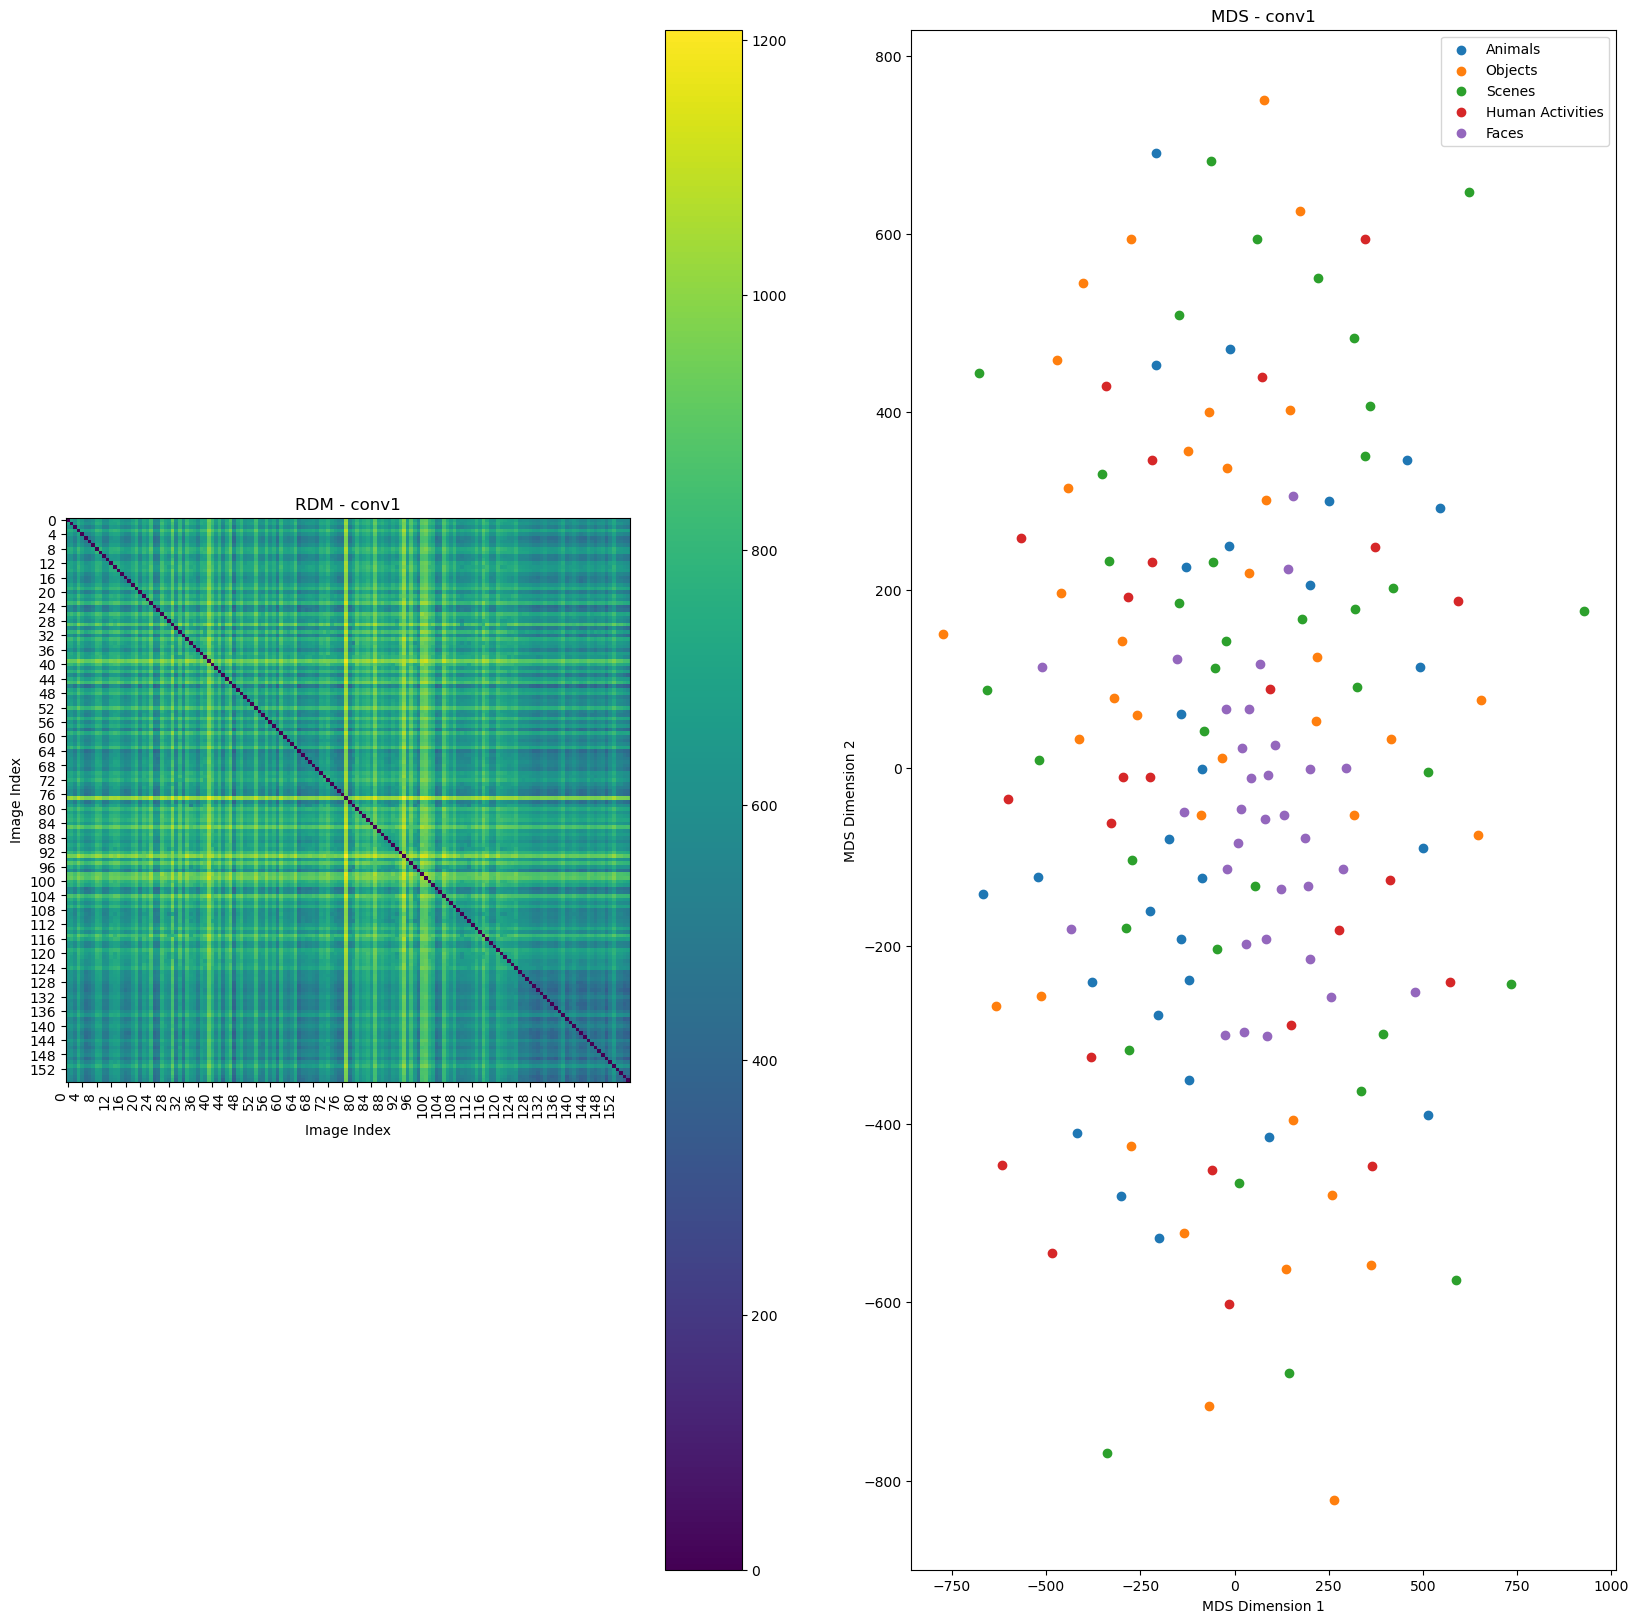

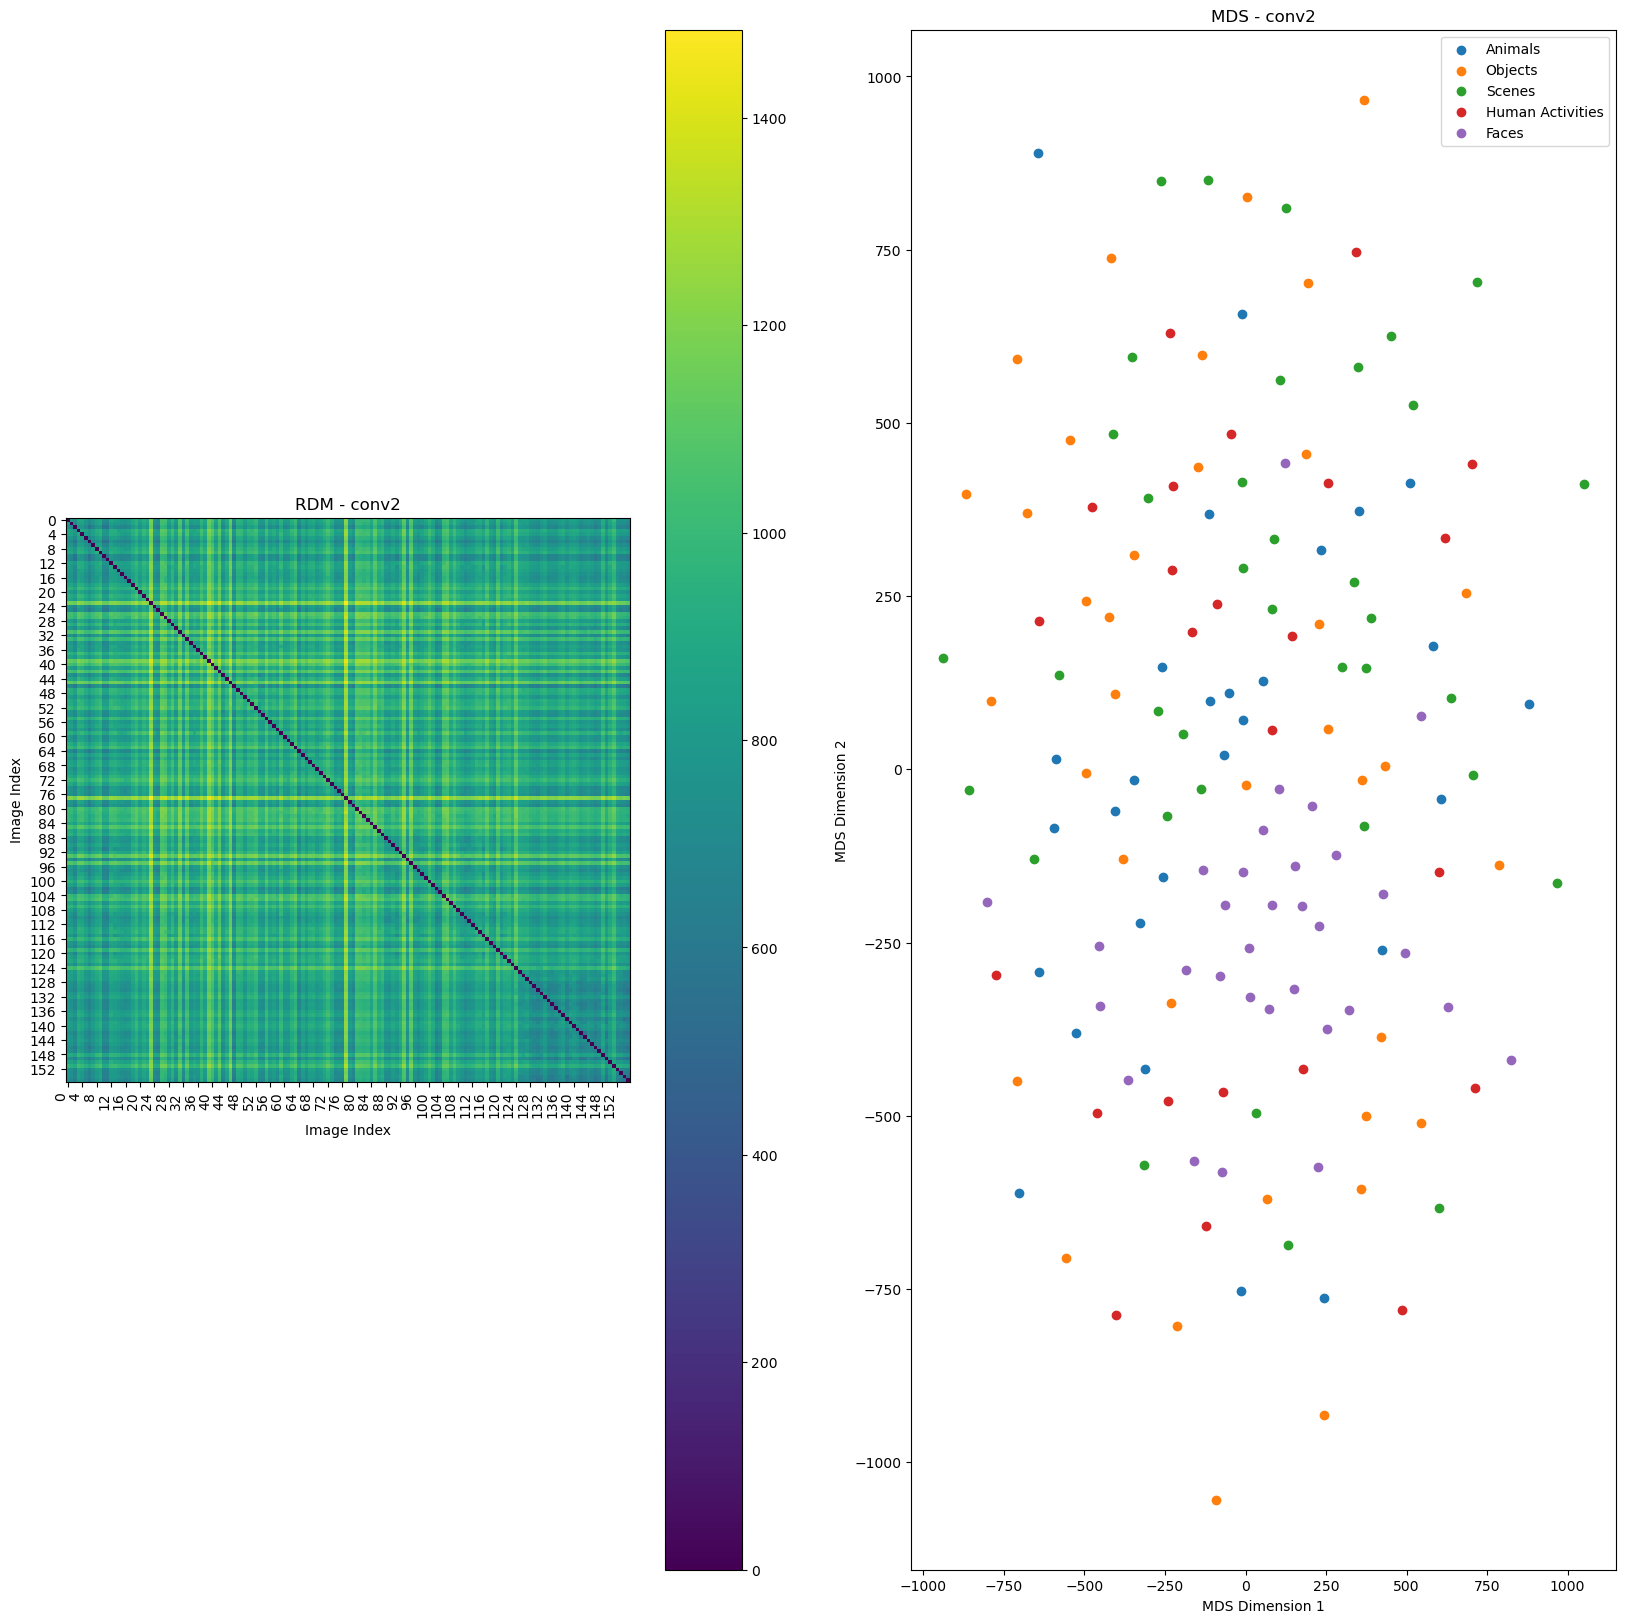

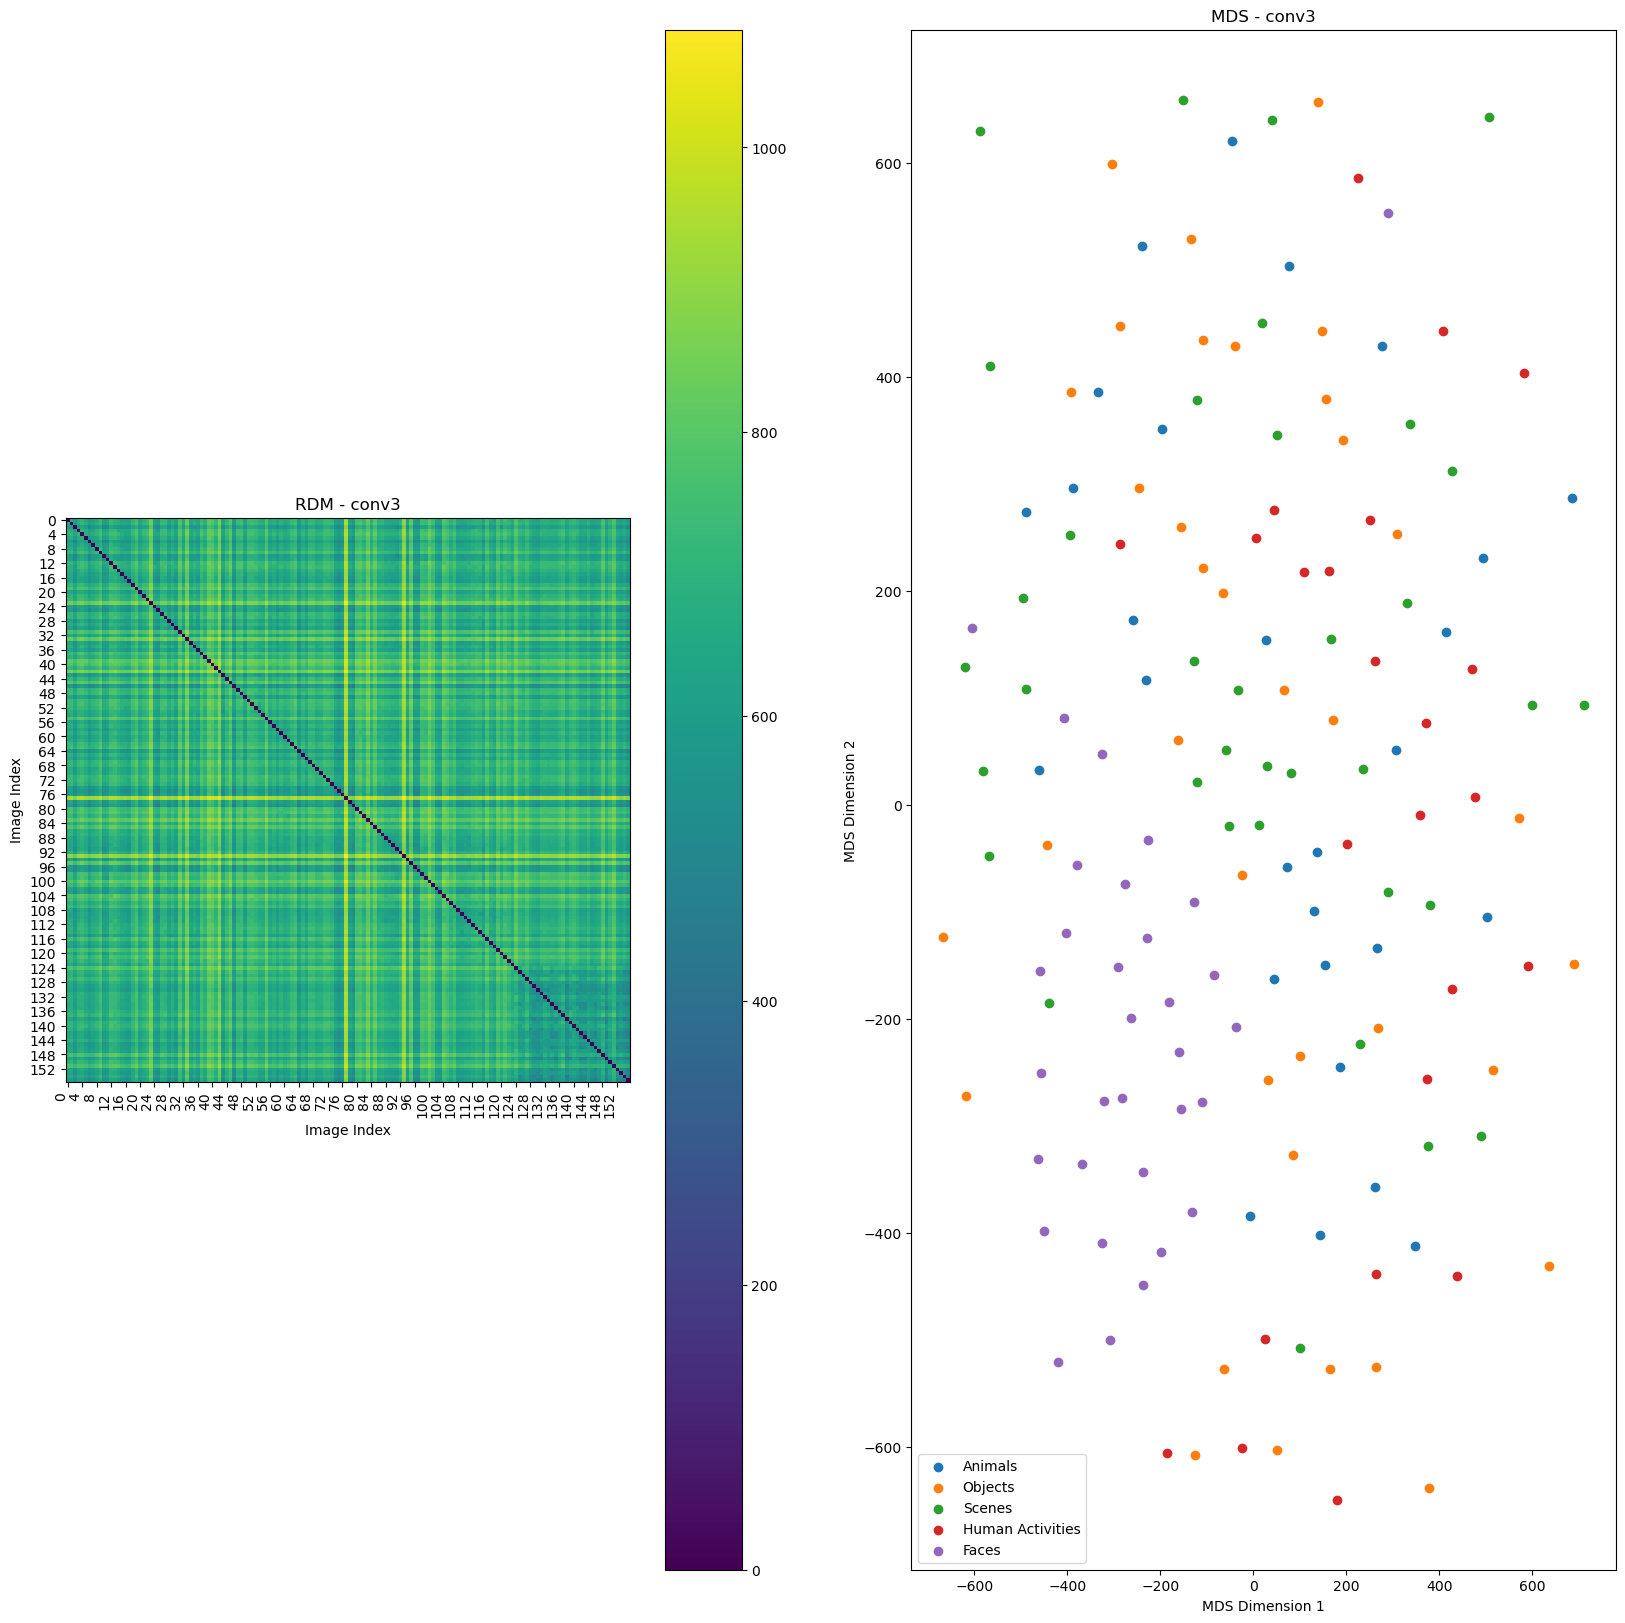

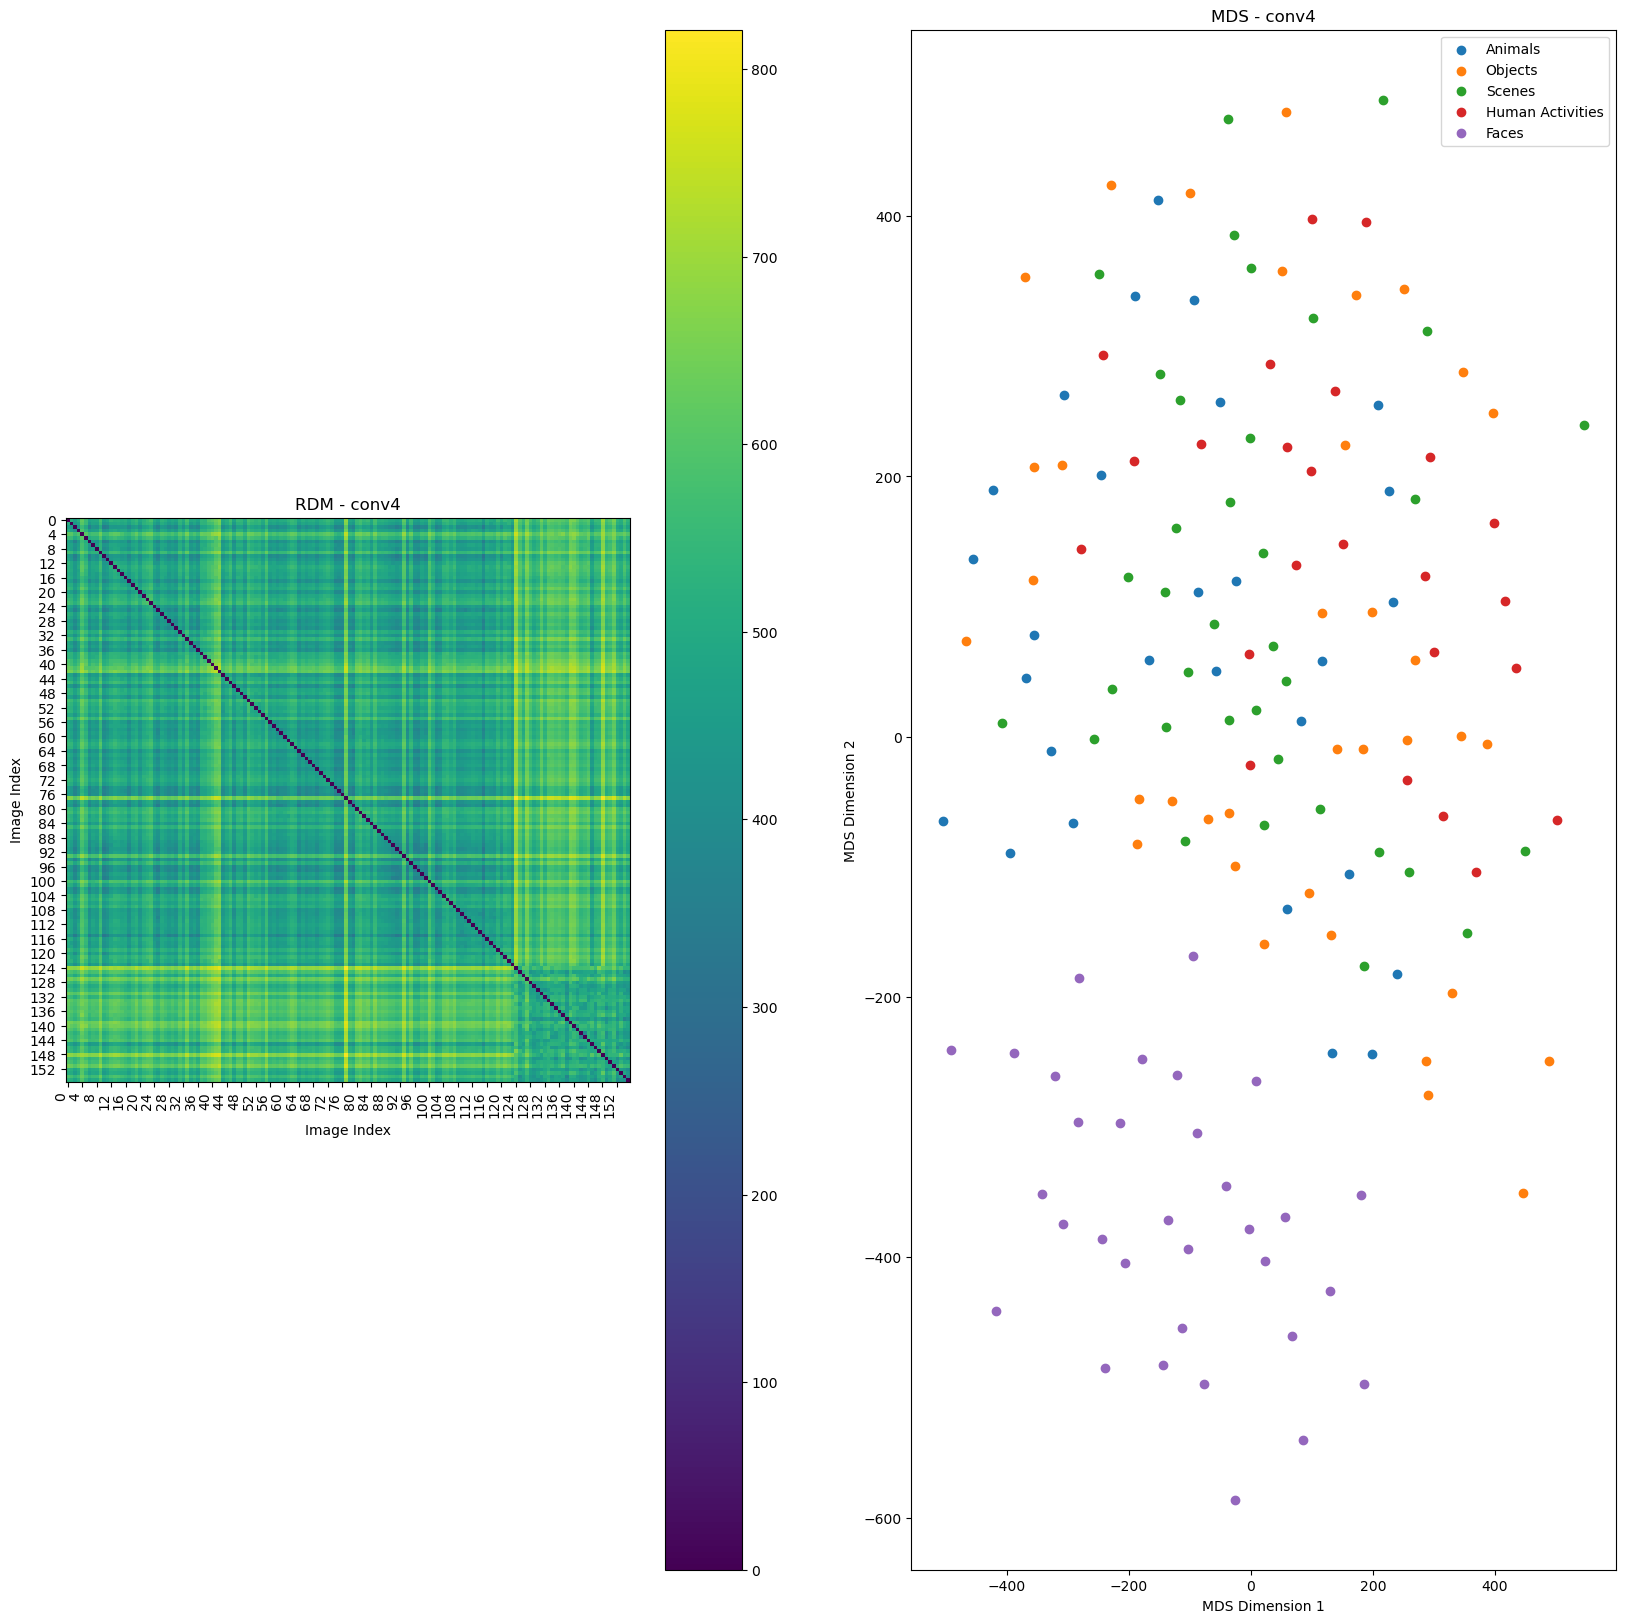

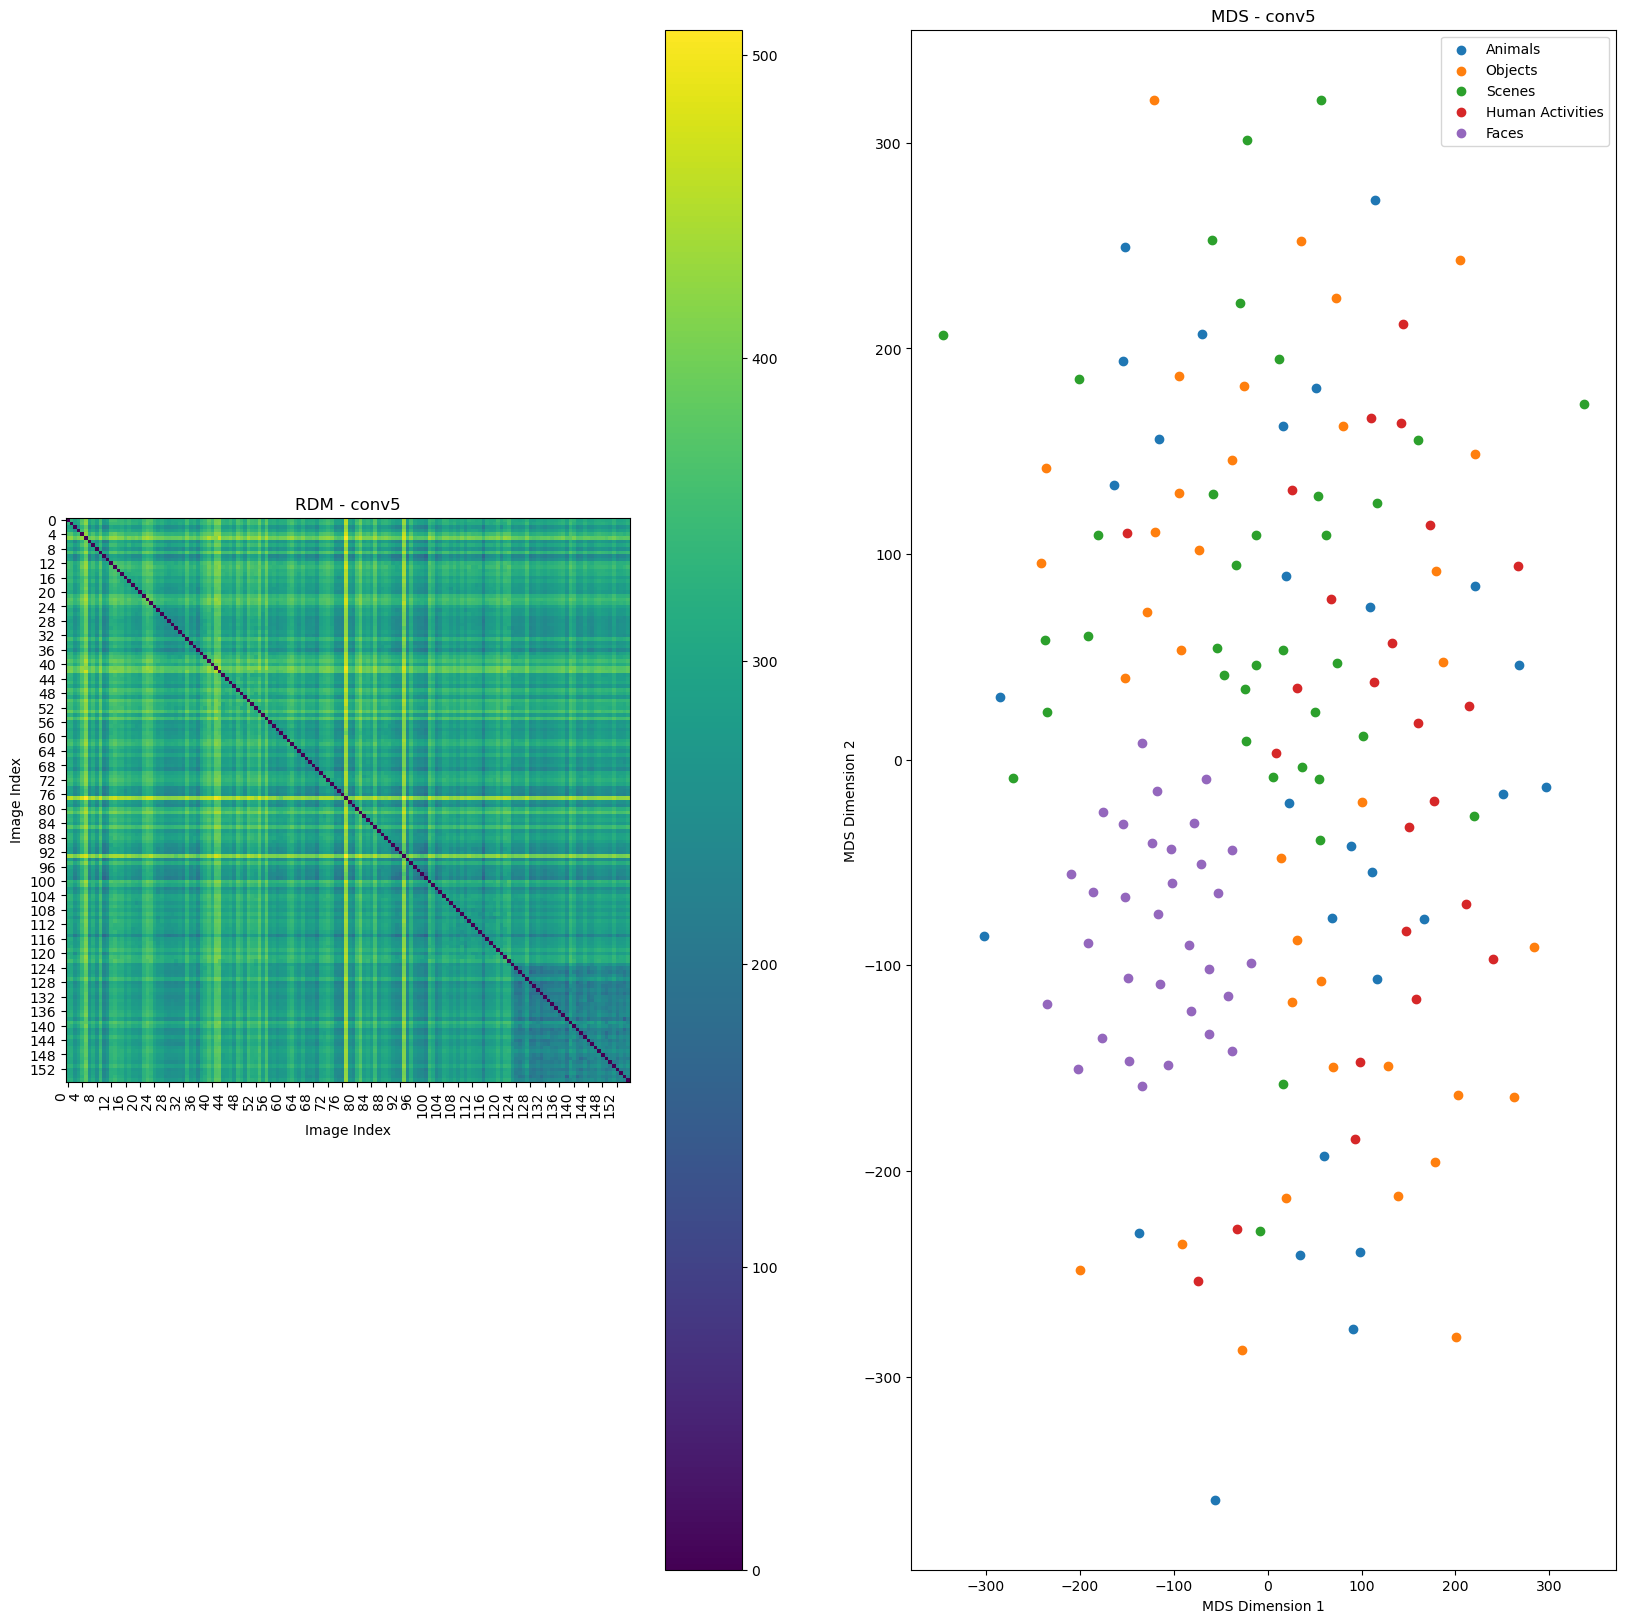

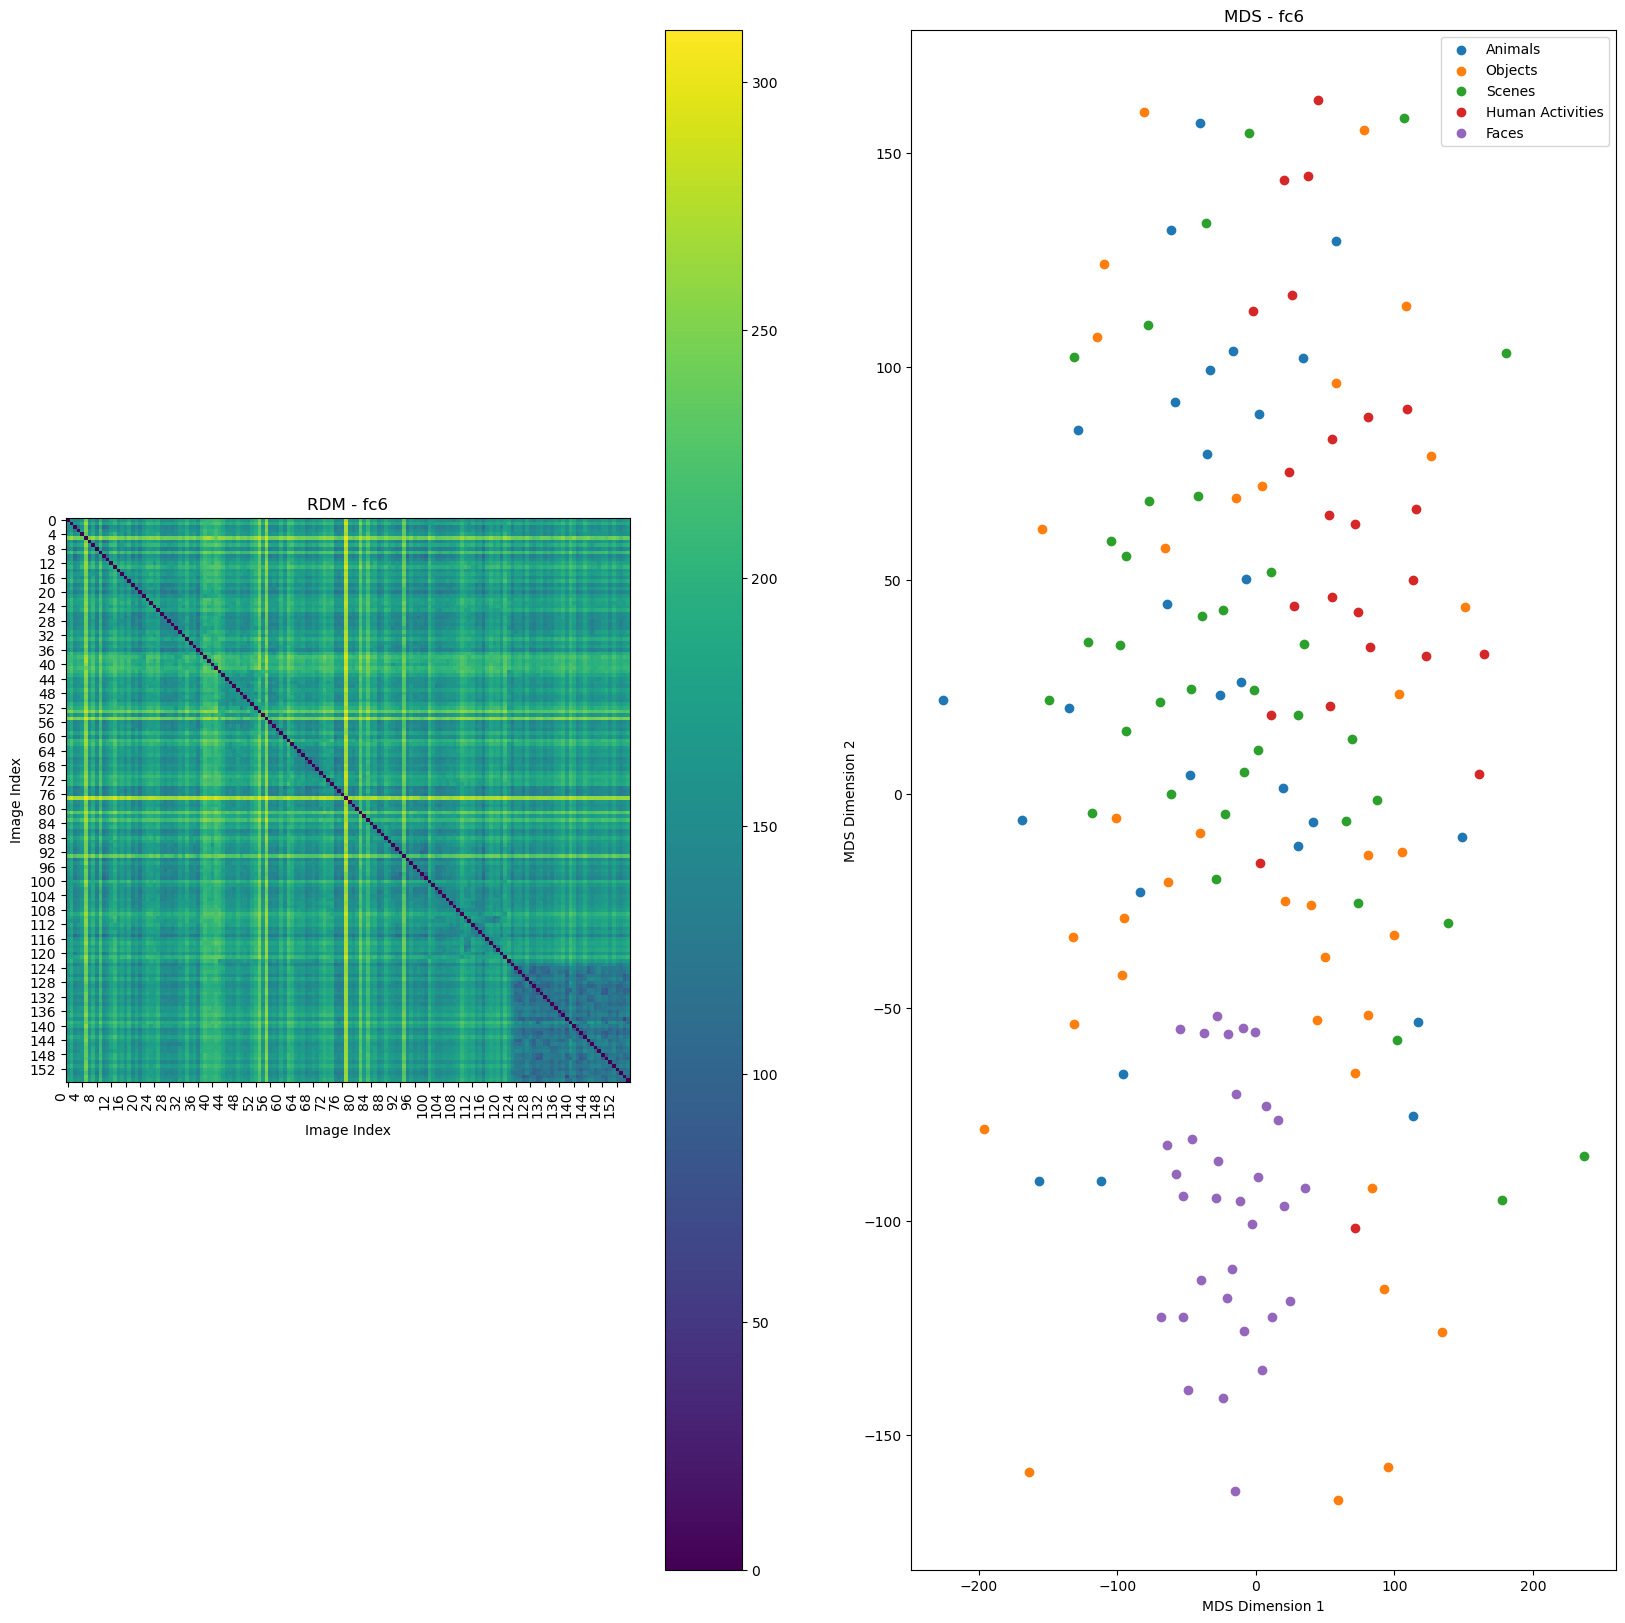

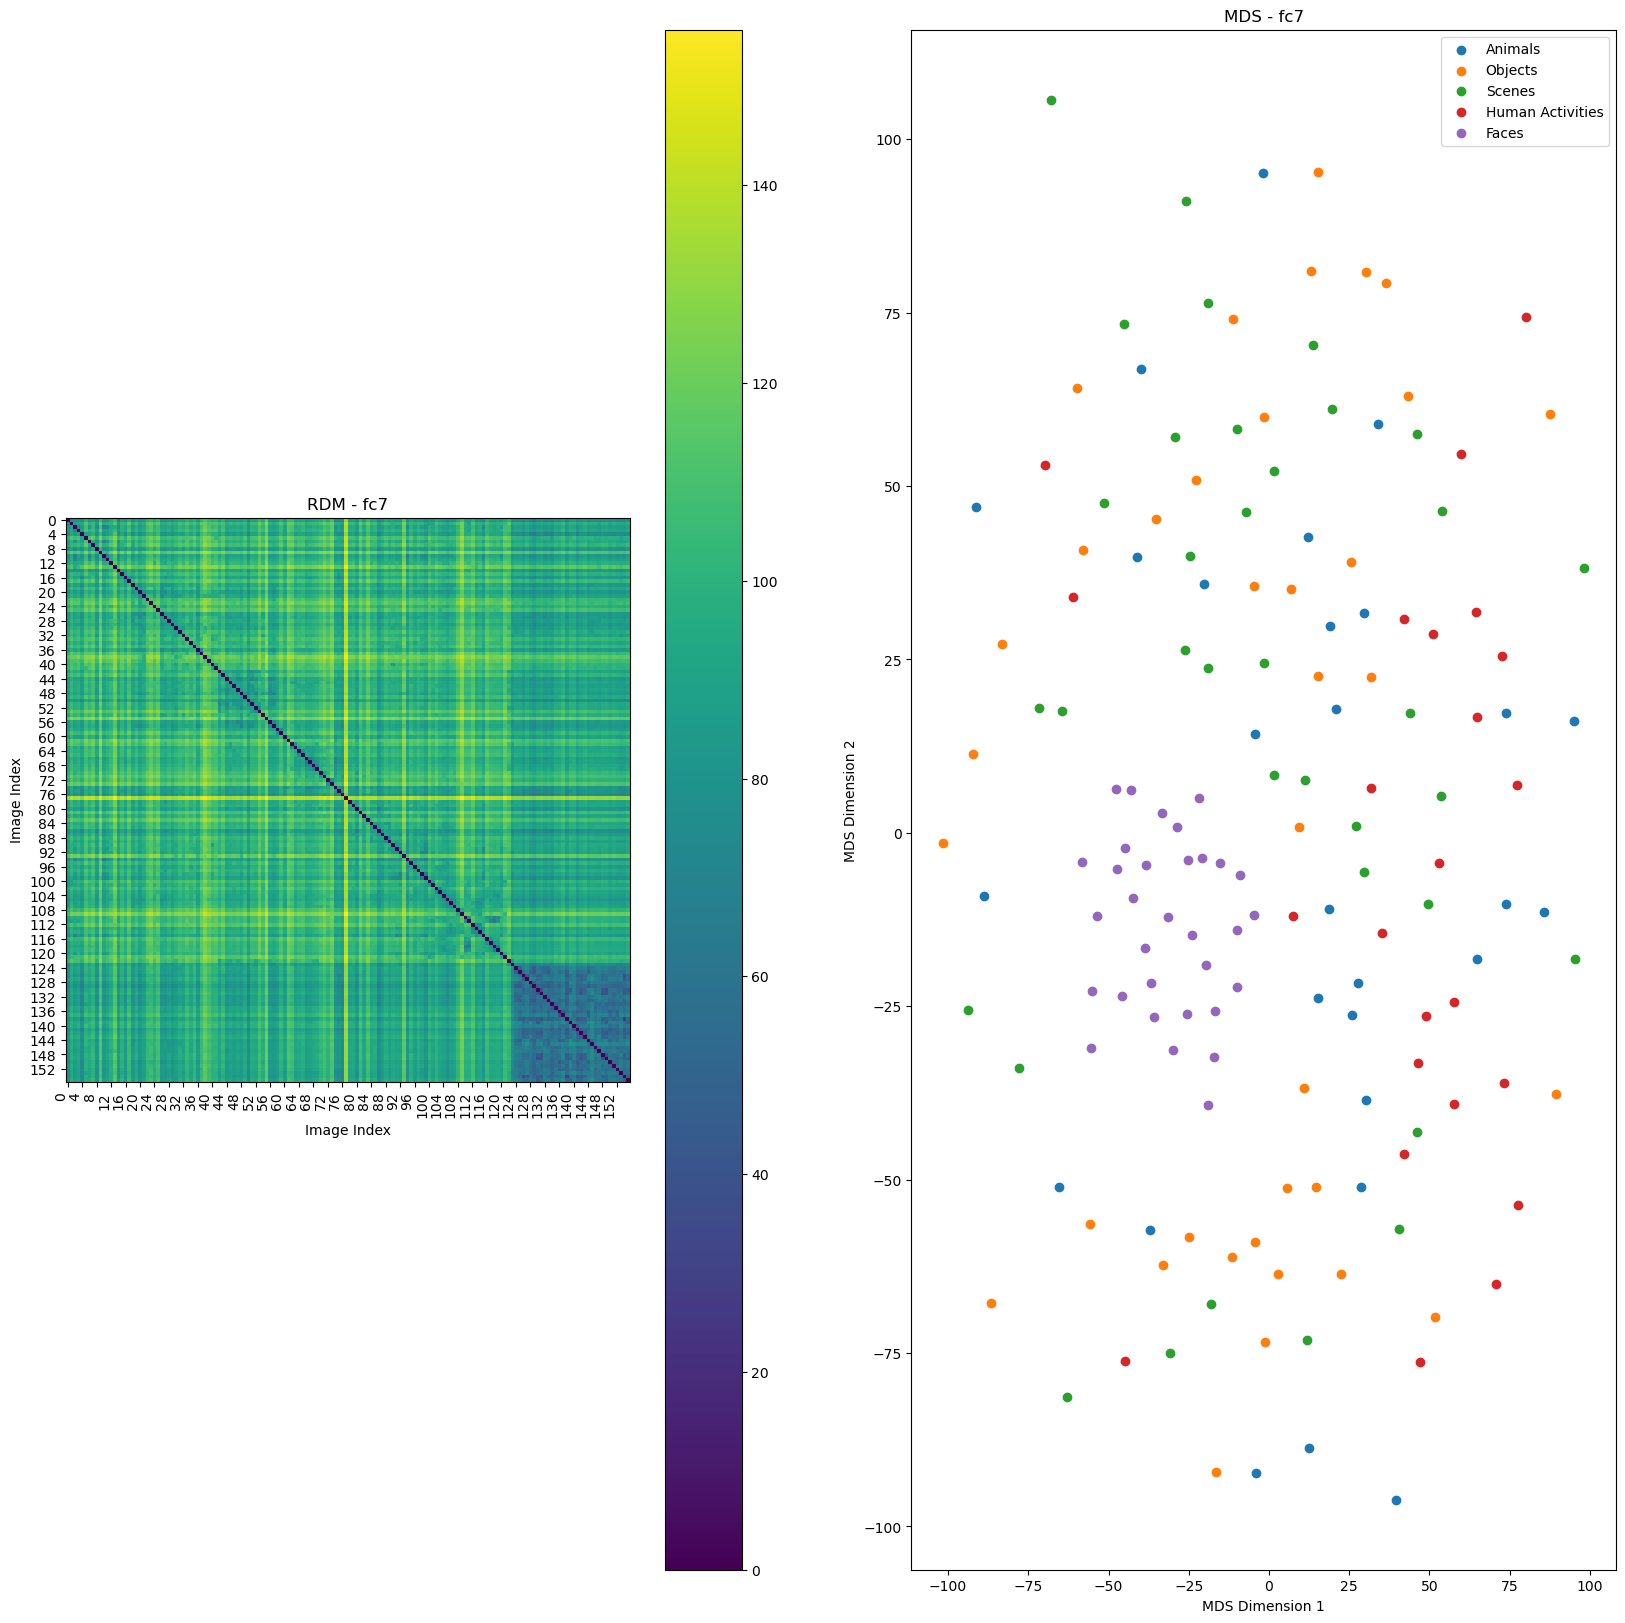

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
# from scipy.spatial import distance

# Load pre-trained AlexNet model
# alexnet = models.alexnet(pretrained=True)
alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Set the model to evaluation mode
alexnet.eval()

# # Freeze parameters
# for param in alexnet.parameters():
#     param.requires_grad = False

# Define transforms to preprocess the images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    # transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## Step 1

# Function to extract features from specified layers
def extract_features(image_path, layers):
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0)
    
    # Define hooks to extract features from specified layers
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    hooks = []

    for layer_name, layer in layers.items():
        hook = layer.register_forward_hook(get_activation(layer_name))
        hooks.append(hook)

    # Forward pass through the network
    with torch.no_grad():

        alexnet(image_tensor)

        # output, _ = alexnet(image_tensor)
        # # print(output[0])
        # probabilities = torch.nn.functional.softmax(output[0], dim=0)
        # print(probabilities)

        

    # Remove hooks
    for hook in hooks:
        hook.remove()
        del hook
    del hooks

    # Vectorize activations
    vectorized_activations = {}
    for layer_name, layer in layers.items():
        activation = activations[layer_name]
        # FC layer, might reshape the activation
        if 'fc' in layer_name:
            activation = activation.view(activation.size(0), -1)
        # Convert activation tensor to numpy array and reshape into 1D vector
        vectorized_activations[layer_name] = activation.numpy().flatten()
        # vectorized_activations[layer_name] = activation.cpu().numpy().flatten()

    return vectorized_activations
        


# def get_activations(img, model, layer, layer_name):
#     activations = {}
#     def hook(module, input, output):
#         activations[layer_name] = output.detach().numpy()
#     layer.register_forward_hook(hook)
#     model(img)
#     return activations[layer_name]


# # Function to extract features from specified layers
# def extract_features2(image_path, layers):
#     image = Image.open(image_path)
#     image_tensor = preprocess(image)
    
#     vectorized_activations = {}

#     with torch.no_grad():
#     # for i, im in enumerate(images):
#         # img_tensor = transform(im)
#         activations = []
#         for layer_name, layer in layers.items():  # Adjusted the range to match the layers in AlexNet
#             layer_activations = get_activations(image_tensor.unsqueeze(0), alexnet, layer, layer_name)
#             layer_activations_flat = layer_activations.flatten()
#             vectorized_activations[layer_name] = layer_activations_flat
#     return vectorized_activations





# List of image paths
data_path = "Image Set"
image_files = os.listdir(data_path)

## Alexnet Con1..5 and fc 6,7 features after ReLU activation
# Desired layers
layers = {
    'conv1': alexnet.features[1],
    'conv2': alexnet.features[4],
    'conv3': alexnet.features[7],
    'conv4': alexnet.features[9],
    'conv5': alexnet.features[11],
    'fc6': alexnet.classifier[2],
    'fc7': alexnet.classifier[5]
}

# layers = {
#     'conv1': alexnet.features._modules['1'],
#     'conv2': alexnet.features._modules['4'],
#     'conv3': alexnet.features._modules['7'],
#     'conv4': alexnet.features._modules['9'],
#     'conv5': alexnet.features._modules['11'],
#     'fc6': alexnet.classifier._modules['2'],
#     'fc7': alexnet.classifier._modules['5']
# }


# Dictionary to store vectorized activations per image per layer
image_activations = {}

# Iterate through each image
for image_file in image_files:
    image_path = os.path.join(data_path, image_file)
    activations = extract_features(image_path, layers)
    # activations = extract_features2(image_path, layers)
    image_activations[image_file] = activations

# sort the activations oder by the name of the file
image_activations = dict(sorted(image_activations.items()))

# print(image_activations)
# print(image_activations["Image Set/001.jpg"])
# print(image_activations["001.jpg"]['conv1'])




## Step 2

# Calculate Euclidean distance between two vectors
def euclidean_distance(vector1, vector2):
    if not isinstance(vector1, np.ndarray):
        vector1 = np.array(vector1)
    if not isinstance(vector2, np.ndarray):
        vector2 = np.array(vector2)
    rdm = np.linalg.norm(vector1 - vector2)

    # rdm = distance.euclidean(vector1, vector2)

    return rdm

# Function to compute RDM
def compute_RDM(image_activations, lable_name):
    num_images = len(image_activations)
    rdm = np.zeros((num_images, num_images))
    # print(image_activations.items())
    # Iterate over pairs of images
    for i, (image_path1, activations1) in enumerate(image_activations.items()):
        for j, (image_path2, activations2) in enumerate(image_activations.items()):
            actX = activations1[lable_name]
            actY = activations2[lable_name]
            # Compute Euclidean distance between activation vectors
            distance = euclidean_distance(actX, actY)
            # Store distance in RDM
            rdm[i, j] = distance
    
    # rdm_np = np.array(rdm)
    # print(rdm_np.shape)
    return rdm





## Step 3

def plot_RDM(rdm, layer_name, amounts):
# def plot_RDM(rdm, layer_name):

    xValues = np.arange(0, amounts - 1, 4)
    yValues =np.arange(0, amounts - 1, 4)

    plt.figure(figsize=(20, 20))

    # Plot RDM
    plt.subplot(1, 2, 1)
    plt.imshow(rdm, cmap='viridis', origin='upper', interpolation='nearest')
    plt.title(f'RDM - {layer_name}')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')

    plt.xticks(xValues, rotation=90, ha='right')
    plt.yticks(yValues)

    plt.colorbar()


    plt.subplot(1, 2, 2)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
    # mds = MDS(n_components=2, dissimilarity='precomputed')

    embeddings = mds.fit_transform(rdm)


    # Step 2: Plot the MDS embeddings
    class_ranges = {
        'Animals': range(0, 28),
        'Objects': range(28, 64),
        'Scenes': range(64, 100),
        'Human Activities': range(100, 124),
        'Faces': range(124, 156)
    }

    # plt.figure(figsize=(10, 8))
    for class_name, indices in class_ranges.items():
        class_embeddings = embeddings[indices]
        plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], label=class_name)

    plt.title(f'MDS - {layer_name}')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')

    # plt.xticks(xValues)
    # plt.yticks(yValues)

    plt.legend()
    plt.show()


    plt.show()


# # Compute RDM
# rdm_matrix_conv1 = compute_RDM(image_activations, 'conv1')
# # plot_RDM(rdm_matrix_conv1, 'conv1')
# plot_RDM(rdm_matrix_conv1, 'conv1', len(image_activations))


# rdm_matrix_fc6 = compute_RDM(image_activations, 'fc7')
# # plot_RDM(rdm_matrix_conv1, 'fc6', len(image_activations))
# plot_RDM(rdm_matrix_fc6, 'fc7', len(image_activations))




for layer_name in layers.keys():
    rdm_matrix_label = compute_RDM(image_activations, layer_name )
    plot_RDM(rdm_matrix_label, layer_name, len(image_activations))

***

## Report

***

Short Report
Introduction:
The goal of the assignment was to explore the feature extractions learned by the AlexNet pre-trained model across Conv 1 to 5 and Fc 6,7. There are 5 categories in the image dataset. After getting the activations of each layer, we create a representational dissimilarity matrix (RDM) via Euclidean distance between vectors of activation of corresponding images for each layer. Then we visualize the RDM using multidimensional scaling (MDS) in 2D dimensions.

Method:
In this assignment, I utilized PyTorch for the deep learning framework to load the pre-train AlexNet model. I have 156 images provided for the input of AlexNet to extract features maps from the layers discussed above. All feature maps/activations were vectorized and were used for RDM using Euclidean distance between activation vectors. After, I use MDS to visualize the dissimilarities between activations in a 2D space.

Result:
Convolutional Layers (Conv 1 to 5):
In Conv 1,2,3, the RDMs showed that the layers captured low-level features. That is the reason why they have higher dissimilarities between images.
In Conv 4,5, the dissimilarities decreased, which indicated that the layers capture higher-level features.
In MDS, similar images were starting to grouped closely together especially the face class.

Fully Connected (FC) Layers (fc 6, 7):
The RDMs showed even lower dissimilarity between images than convolutional layers. This states that the FC layers successfully encoded more semantic information.
MDS showed that there is separation between different categories, and similar images are even closer to each other. This revealed the model learns the representation for different similar images and image classes. The model will identify face images.

Conclusion:
The results demonstrate that the feature maps learned by AlexNet advanced from low-level to high-level. The RDMs showed the convolutional layers learned the basic features of images. And the MDS showed that fully connected layers learned the encoded representation of different image categories. 
The final ouput indicate that the model have learned the feature of each class image because MDSs showes that they are from chaotic, disorder to become order based on image similarity, and different image classes. The model  have high accuracy when identify face images.

***